In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# NEW CLASS AND ACTIVATION FUNCTIONS RUN THIS

In [126]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [127]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T   

In [128]:
def ReLU(x):
    return x * (x > 0)

In [129]:
def ReLU_grad(x):
    return 1. * (x > 0)

In [130]:
def tanh(z):
    e = np.exp(2*z)
    return 1-2/(e+1)

In [131]:
def tanh_grad(z):
    return 1-tanh(z)**2

In [132]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [133]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [134]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [135]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [136]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [137]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [138]:
def identity(x):
    return x

In [139]:
def identity_grad(x):
    return 1

In [148]:
class MLP_new:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 acti_funs,acti_funs_grad,cost_fun,cost_fun_grad,seed=123):
        
        np.random.seed(seed)
        
        self.acti_funs=acti_funs
        self.acti_funs_grad=acti_funs_grad
        
        self.cost_fun=cost_fun
        self.cost_fun_grad=cost_fun_grad
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.acti_funs[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.acti_funs[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.acti_funs[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,train_output_layer,max_epoch=2000,rate=0.1,beta=0,batch=1,stop=10**-6,RMSprop=False,
              L1=False,L2=False,eps=10**-8,alpha=0.01,validate=False,early_stop=3,test_input_layer=0,test_output_layer=0,return_error_list=True,Verbose=True):
        #creating batches
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)+1).round().astype(int)
        #initiating errors
        output_layer=self.calculate(train_input_layer)
        error=self.cost_fun(train_output_layer,output_layer)
        #initiating early stopping
        warning=0
        if validate:
            output_layer=self.calculate(test_input_layer)
            error_test=self.cost_fun(test_output_layer,output_layer)
        
        print("start error "+str(error))
        #initiating old gradient list
        old_grad=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_grad_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,max_epoch+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #all cost funs should be independent from size of vectors because we rescale them later
                    #last acti fun is used at output_layer so for classification it should be softmax and for regresion identity
                    errors[x][-1]=((self.cost_fun_grad(train_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.acti_funs_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.acti_funs_grad[i](self.hidden_layers[i][:,x:x+1])
                
                for l in range(1,len(self.weights)):
                    #we rescale by batch size here
                    #new_grad=np.clip(new_grad,-10**6,10**6) is used to prevent weights exploding
                    #we update grads beta here is momentum
                    if(RMSprop):
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        #print("hello")
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        #regularization
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        #updating gradients
                        old_grad[l][b]=beta*old_grad[l][b]+(1-beta)*new_grad**2
                        self.weights[l]=self.weights[l]-new_grad*(rate/(np.sqrt(old_grad[l][b])+eps))

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        old_grad_bias[l][b]=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias**2
                        self.biases[l]=self.biases[l]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[l][b])+eps))
                    else:
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        #print("pepega")
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        new_grad=beta*old_grad[l][b]+(1-beta)*new_grad
                        old_grad[l][b]=new_grad
                        self.weights[l]=self.weights[l]-new_grad*rate

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                        new_grad_bias=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias
                        old_grad_bias[l][b]=new_grad_bias
                        self.biases[l]=self.biases[l]-new_grad_bias*rate

                if(RMSprop):
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    old_grad[0][b]=beta*old_grad[0][b]+(1-beta)*new_grad**2
                    self.weights[0]=self.weights[0]-new_grad*(rate/(np.sqrt(old_grad[0][b])+eps))

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    old_grad_bias[0][b]=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias**2
                    self.biases[0]=self.biases[0]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[0][b])+eps))
                else:
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    new_grad=beta*old_grad[0][b]+(1-beta)*new_grad
                    old_grad[0][b]=new_grad
                    self.weights[0]=self.weights[0]-new_grad*rate

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    new_grad_bias=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias
                    old_grad_bias[0][b]=new_grad_bias
                    self.biases[0]=self.biases[0]-new_grad_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_fun(train_output_layer,output_layer)
            
            #check stopping conditions if worse early_stop a row then stop
            if validate:
                output_layer=self.calculate(test_input_layer)
                new_error_test=self.cost_fun(test_output_layer,output_layer)
                if new_error_test>error_test:
                    if warning>=early_stop:
                        break
                    else:
                        error_test=new_error_test
                        warning+=1
                else:
                    error_test=new_error_test
                    warning=0
                
            if return_error_list:
                error_list.append(new_error)
            
            if(epoch % 500 == 0 and Verbose):
                print("epoch "+str(epoch))
                
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("end in epoch "+str(epoch)+ " with error "+str(new_error))
        if return_error_list:
            return error_list
        else:
            return new_error

# Regularization RUN THIS

In [149]:
df=pd.DataFrame(columns=["problem","dataset","L1","L2","regularization","validate","accuracy_train","accuracy_test"])

In [150]:
networks=[]

networks_names=[]

networks_err=[]

np.random.seed(123)

# increase this for better results but longer computations

In [158]:
test = np.loadtxt("mio1/classification/xor3-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [159]:
test = np.loadtxt("mio1/classification/xor3-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

In [160]:
MAX_EPOCH=300

In [161]:
mlp_test=MLP_new(2,2,[5,6,7],[sigmoid]*3+[softmax],[sigmoid_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)

In [162]:
[w.shape for w in mlp_test.weights]

[(5, 2), (6, 5), (7, 6), (2, 7)]

In [182]:
mlp_test.train(train_input_layer,train_output_layer,batch=0.33,
                              rate=0.5,beta=0.99,max_epoch=MAX_EPOCH,RMSprop=True)

start error 6907.755278982387
end in epoch 1 with error 6907.755278982387


[6907.755278982387, 6907.755278982387]

accuracy train
0.5
accuracy test
0.588


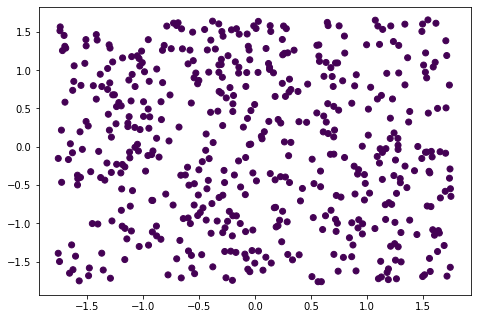

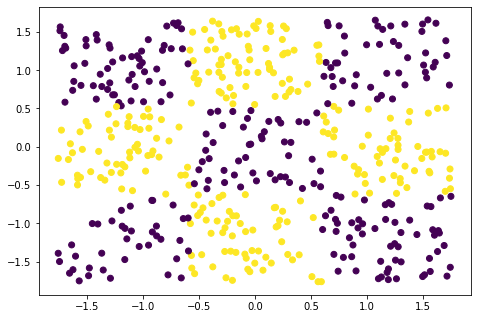

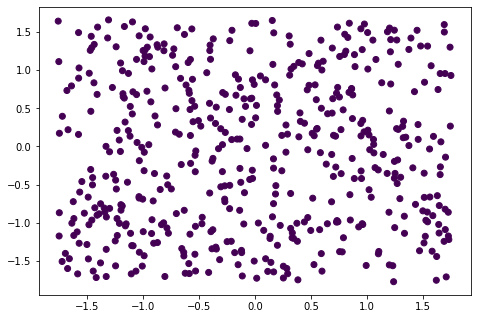

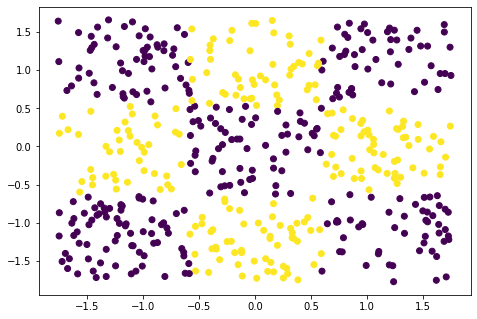

In [183]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

In [108]:
[w.shape for w in mlp_test.weights]

[(5, 2), (6, 5), (7, 6), (5, 7)]

# rings5-sparse

In [72]:
test = np.loadtxt("mio1/classification/easy-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [73]:
test = np.loadtxt("mio1/classification/easy-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [31]:
mlp_start=MLP_new(2,2,[6,7,8],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
for L in ["L1","L2","None"]:
    for W in [True,False]:
        mlp_test=MLP_new(2,5,[5,6,7],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        if W:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
        else:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH)
        
        
        
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("rings5-sparse-"+L+"-"+str(W))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        L1=sum([np.sum(w**2) for w in mlp_test.weights])
        L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
        df=df.append({"problem":"classification","dataset":"rings5-sparse","L1":L1,"L2":L2,"regularization":L,"validate":W,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 966.6095218251564
end in epoch 300 with error 27.294144400980432


NameError: name 'networks' is not defined

accuracy train
0.996
accuracy test
0.974


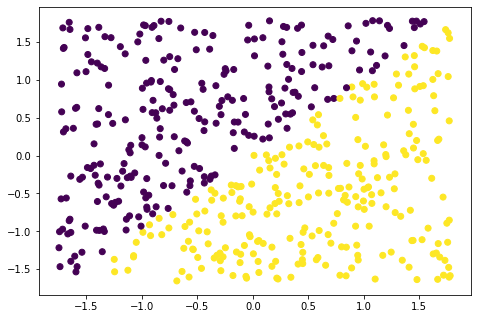

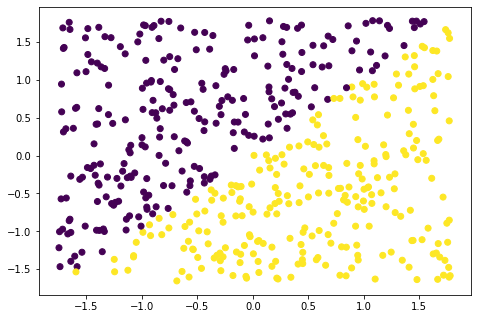

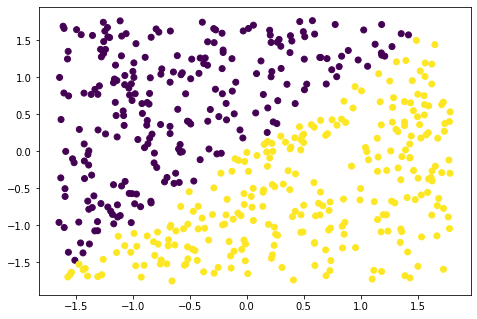

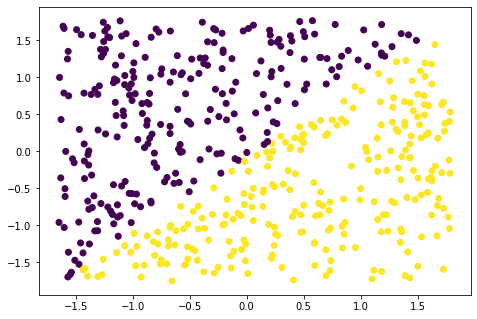

In [32]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# rings3-balance

In [44]:
test = np.loadtxt("mio1/classification/rings3-balance-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [45]:
test = np.loadtxt("mio1/classification/rings3-balance-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [46]:
mlp_start=MLP_new(2,3,[6,7,8],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
for L in ["L1","L2","None"]:
    for W in [True,False]:
        mlp_test=MLP_new(2,3,[5,6,7],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        if W:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
        else:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH)
        
        
        
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("rings3-balance-"+L+"-"+str(W))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        L1=sum([np.sum(w**2) for w in mlp_test.weights])
        L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
        df=df.append({"problem":"classification","dataset":"rings3-balance","L1":L1,"L2":L2,"regularization":L,"validate":W,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 3663.183147717529
end in epoch 10 with error 1644.8471358394904
start error 3663.183147717529
end in epoch 210 with error 1725.253207185957
start error 3663.183147717529
end in epoch 10 with error 1614.7284860551624
start error 3663.183147717529
end in epoch 300 with error 1476.2188745562562
start error 3663.183147717529
end in epoch 10 with error 1587.6059232397529
start error 3663.183147717529
end in epoch 300 with error 791.3587626322651


accuracy train
0.874757281553398
accuracy test
0.5495


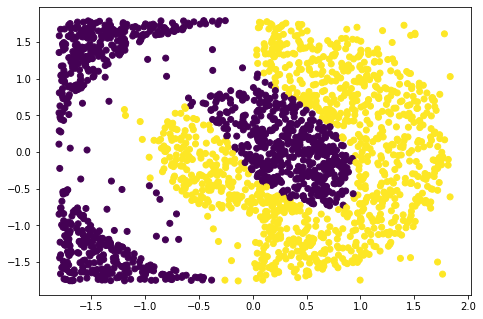

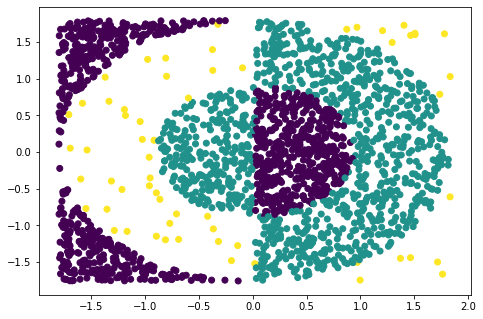

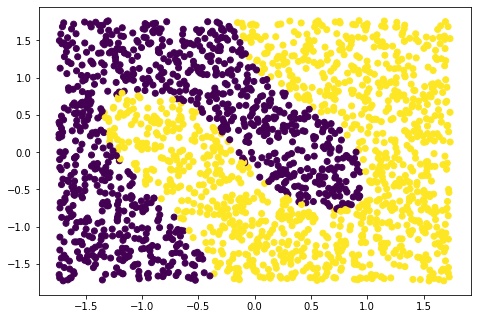

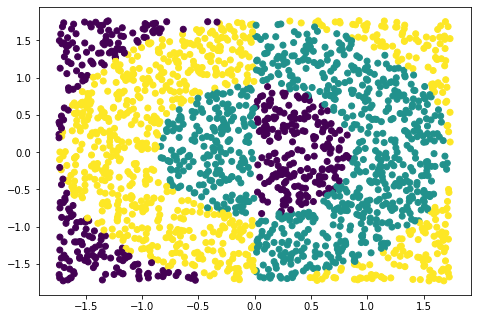

In [47]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# xor3-balance

In [48]:
test = np.loadtxt("mio1/classification/xor3-balance-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [49]:
test = np.loadtxt("mio1/classification/xor3-balance-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [50]:
mlp_start=MLP_new(2,2,[6,7,8],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
for L in ["L1","L2","None"]:
    for W in [True,False]:
        mlp_test=MLP_new(2,5,[5,6,7],[tanh]*3+[softmax],[tanh_grad]*3+[softmax_grad],cross_entropy,cross_entropy_grad)
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        if W:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
        else:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH)
        
        
        
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("xor3-balance-"+L+"-"+str(W))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        L1=sum([np.sum(w**2) for w in mlp_test.weights])
        L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
        df=df.append({"problem":"classification","dataset":"xor3-balance","L1":L1,"L2":L2,"regularization":L,"validate":W,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 1201.3197382423282
end in epoch 6 with error 242.27956237871217
start error 1201.3197382423282
end in epoch 300 with error 217.61724898691352
start error 1201.3197382423282
end in epoch 6 with error 239.35718597546133
start error 1201.3197382423282
end in epoch 190 with error 211.34377667906296
start error 1201.3197382423282
end in epoch 6 with error 238.97436230970266
start error 1201.3197382423282
end in epoch 300 with error 203.41919793728408


accuracy train
0.9523809523809523
accuracy test
0.5525


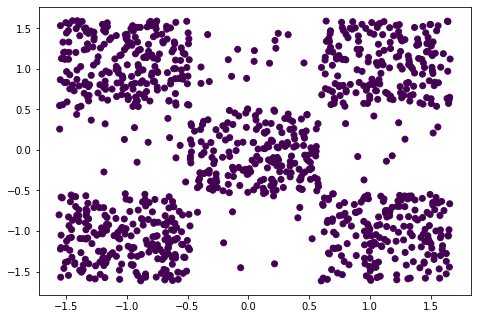

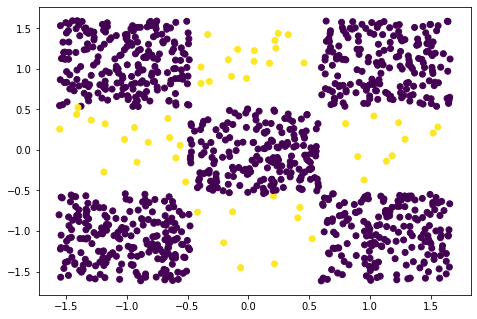

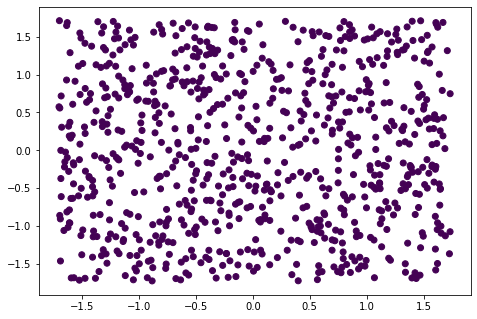

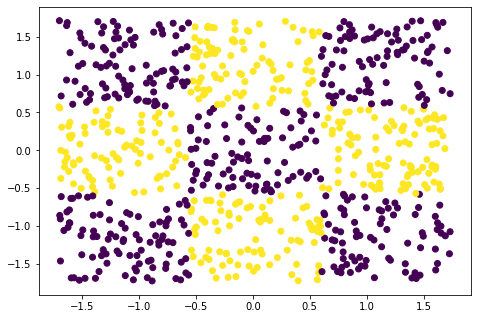

In [51]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# multimodal-sparse

In [52]:
test = np.loadtxt("mio1/regression/multimodal-sparse-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [53]:
test = np.loadtxt("mio1/regression/multimodal-sparse-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [54]:
mlp_start=MLP_new(1,1,[6,7,8],[tanh]*3+[identity],[tanh_grad]*3+[identity_grad],MSE,MSE_grad)
for L in ["L1","L2","None"]:
    for W in [True,False]:
        mlp_test=MLP_new(1,1,[5,6,7],[tanh]*3+[identity],[tanh_grad]*3+[identity_grad],MSE,MSE_grad)
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        if W:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,validate=True,
                              test_input_layer=test_input_layer,test_output_layer=test_output_layer)
        else:
            if L=="L1":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L1=True)
            if L=="L2":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH,L2=True)
            if L=="None":
                er=mlp_test.train(train_input_layer,train_output_layer,batch=1,
                              rate=0.05,beta=0.1,max_epoch=MAX_EPOCH)
        
        
        
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("multimodal-sparse-"+L+"-"+str(W))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=MSE(train_output_layer,output_layer)/output_layer.shape[0]
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=MSE(test_output_layer,output_layer)/output_layer.shape[0]
        L1=sum([np.sum(w**2) for w in mlp_test.weights])
        L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
        df=df.append({"problem":"regression","dataset":"multimodal-sparse","L1":L1,"L2":L2,"regularization":L,"validate":W,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 316432.340120555
end in epoch 249 with error 49546.998865193345
start error 316432.340120555
end in epoch 300 with error 46732.419670608324
start error 316432.340120555
end in epoch 58 with error 29408.632535374734
start error 316432.340120555
end in epoch 164 with error 116609.68518358571
start error 316432.340120555
end in epoch 36 with error 61209.70117877843
start error 316432.340120555
end in epoch 38 with error 61209.57783451071


train MSE
1530.2394458627678
test MSE
5670.37588998659


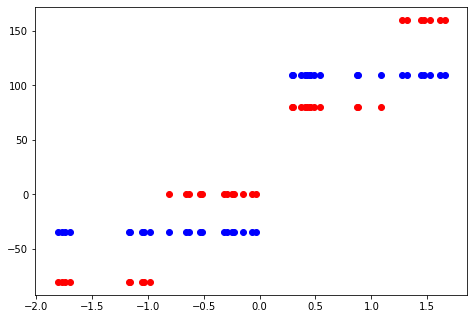

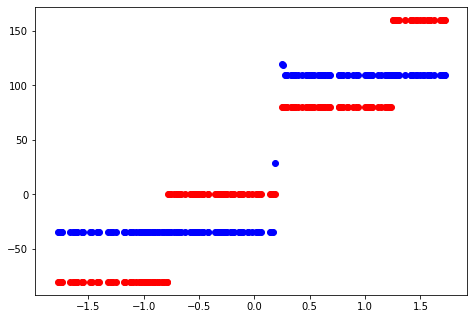

In [55]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
print("train MSE")
print(MSE(train_output_layer,output_layer)/output_layer.shape[0])

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
print("test MSE")
print(MSE(test_input_layer,output_layer)/output_layer.shape[0])

In [58]:
df

,problem,dataset,L1,L2,regularization,validate,accuracy_train,accuracy_test
0,classification,rings5-sparse,22.855150,44.188490,L1,True,0.345000,0.239500
1,classification,rings5-sparse,2.771502,9.915518,L1,False,0.210000,0.385500
2,classification,rings5-sparse,16.474690,42.324139,L2,True,0.380000,0.298500
3,classification,rings5-sparse,16.474690,42.324139,L2,False,0.380000,0.298500
4,classification,rings5-sparse,47.838984,71.078385,None,True,0.500000,0.422500
5,classification,rings5-sparse,47.838984,71.078385,None,False,0.500000,0.422500
6,classification,rings3-balance,28.992297,51.305608,L1,True,0.616505,0.404500
7,classification,rings3-balance,0.063844,0.776072,L1,False,0.485437,0.213000
8,classification,rings3-balance,31.137164,54.972533,L2,True,0.614563,0.407500
9,classification,rings3-balance,4.379337,19.527515,L2,False,0.616505,0.410000


In [59]:
import seaborn as sns

In [60]:
df_c=df[df["problem"]=="classification"]

In [61]:
df_r=df[df["problem"]!="classification"]

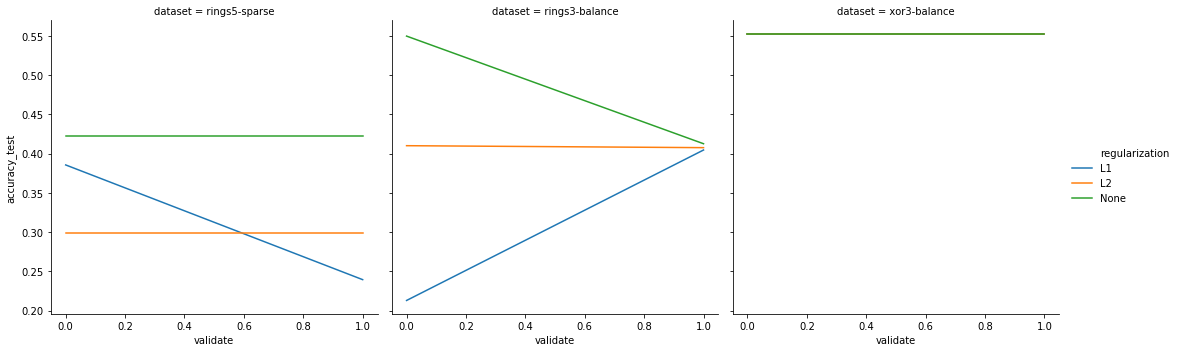

In [63]:
sns.relplot(x="validate",y="accuracy_test",hue="regularization",col="dataset",kind="line",data=df_c)

In [ ]:
#jak widzimy regularyzacja nie wpływa korzystnie na wyniki zaś w przypadku walidacji brak to czasami pomaga, a czasami przeszkadza lub bez wpływu

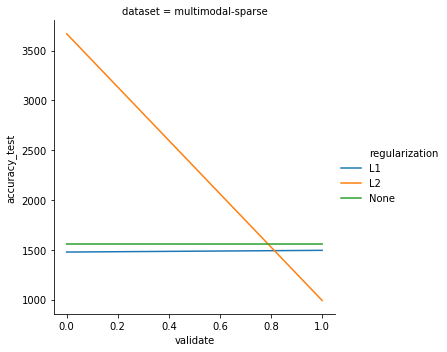

In [64]:
#dla problemu regresji im niżej tym lepiej "accuracy" to w tym wypadku MSE
sns.relplot(x="validate",y="accuracy_test",hue="regularization",col="dataset",kind="line",data=df_r)

In [ ]:
#tutaj regularyzacja L2 i walidacja dały najlepszy wynik 

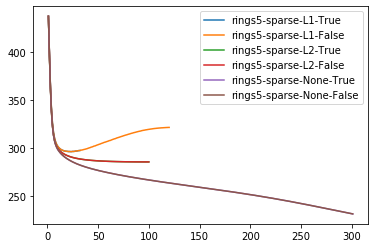

In [74]:
for x in range(0,6):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x])
    
plt.legend(loc="upper right")  

In [ ]:
#tutaj widzimy że zbiór walidacyjny bardzo wcześnie zatrzymał uczenie, widzymy też tendencje L1 bez walidacji do rosnięcia

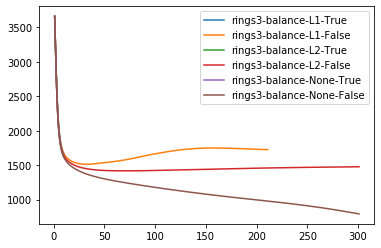

In [71]:
for x in range(6,12):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x])
    
plt.legend(loc="upper right") 

In [ ]:
#tutaj podobne wnioski

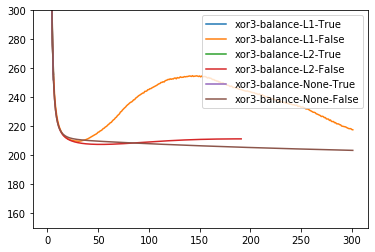

In [83]:
for x in range(12,18):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x])
        plt.ylim(150,300)
    
plt.legend(loc="upper right") 

In [ ]:
#tutaj podobne wnioski

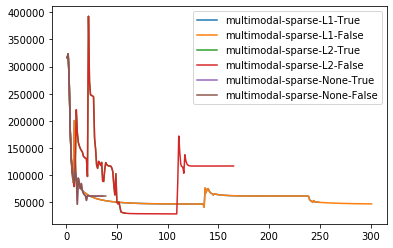

In [73]:
for x in range(18,24):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x])
    
plt.legend(loc="upper right") 

In [ ]:
#nie wiem co się dzieje

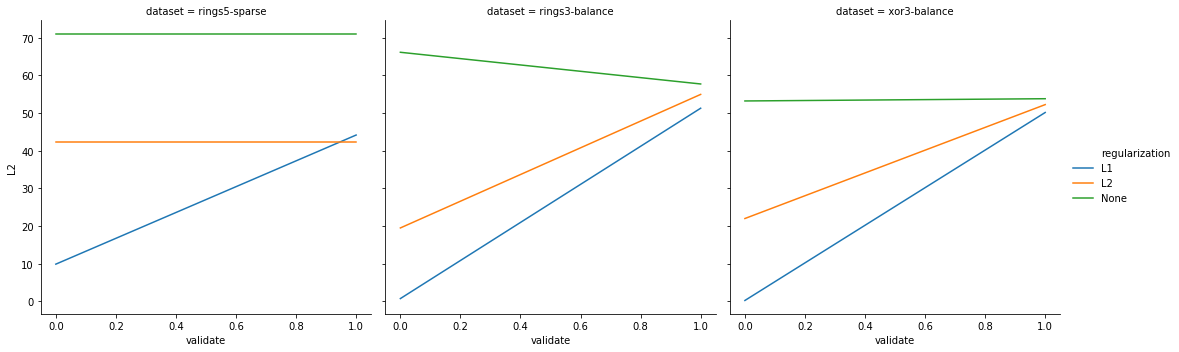

In [85]:
sns.relplot(x="validate",y="L2",hue="regularization",col="dataset",kind="line",data=df_c)

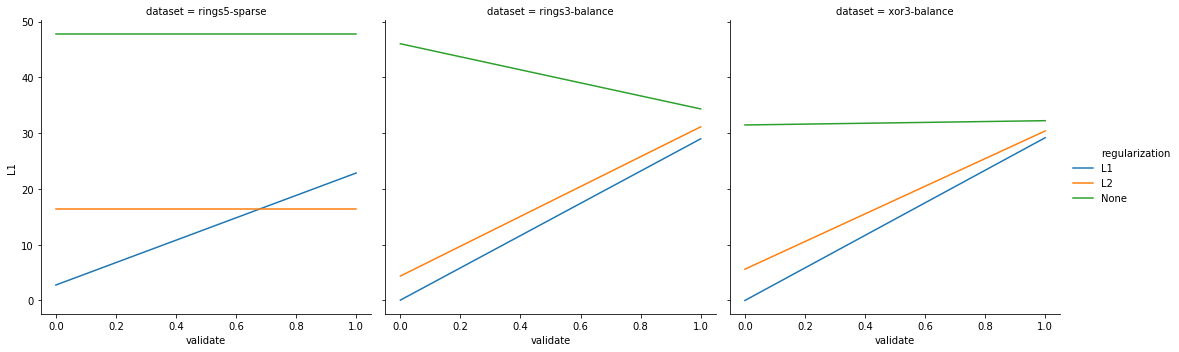

In [86]:
sns.relplot(x="validate",y="L1",hue="regularization",col="dataset",kind="line",data=df_c)

In [ ]:
#tutaj widzimy że regularyzacja działa to znaczy że wagi przy regularyzacji są mniejsze niż bez niej poza tym L1 regularyzacja działa lepiej niż L2,
#nawet przy minimalizacji błędu L2. zbiór walidacyjny sprawia że kary L1 i L2 stają się sobie bliższe dla każdego trybu regularyzacji 

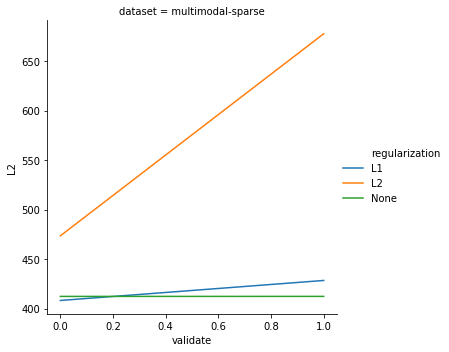

In [87]:
sns.relplot(x="validate",y="L2",hue="regularization",col="dataset",kind="line",data=df_r)

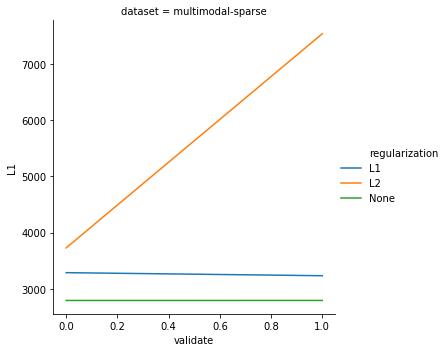

In [89]:
sns.relplot(x="validate",y="L1",hue="regularization",col="dataset",kind="line",data=df_r)

In [90]:
#nie mam pojęcia co się dzieje, ale L2 otrzymało najlepszy wynik na zbiorze testowym(patrz 2 wykres od początku)

# test of diffrent activation functions OLD LAB

In [20]:
df=pd.DataFrame(columns=["problem","dataset","layers","activation_function","accuracy_train","accuracy_test"])

In [21]:
networks=[]

networks_names=[]

networks_err=[]

np.random.seed(123)

# increase this for better results but longer computations

In [25]:
MAX_EPOCH=250

# rings5

In [26]:
test = np.loadtxt("mio1/classification/rings5-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
#-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [27]:
test = np.loadtxt("mio1/classification/rings5-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [28]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(2,5,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(2,5,l,[sigmoid]*len(l)+[softmax],[sigmoid_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(2,5,l,[ReLU]*len(l)+[softmax],[ReLU_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="identity":
             mlp_test=MLP_new(2,5,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(2,5,l,[tanh]*len(l)+[softmax],[tanh_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("ring5-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        df=df.append({"problem":"classification","dataset":"rings5-regular","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 2427.2308971615003
end epoch in 25 with error 2023.5975914582673
start error 2234.9831091410892
end epoch in 25 with error 1958.4299854921092
start error 2900.816305834476
end epoch in 25 with error 1726.8791479770268
start error 2038.5274150140845
end epoch in 25 with error 1730.0319481503243
start error 2205.9960656899193
end epoch in 25 with error 2021.5544726875482
start error 2152.997457841503
end epoch in 25 with error 1942.2475395153092
start error 3573.5669662343976
end epoch in 25 with error 1785.504804835726
start error 2686.618432299965
end epoch in 25 with error 1865.733690480762
start error 2109.5901999931675
end epoch in 25 with error 1925.6897342432455
start error 2105.324830770878
end epoch in 25 with error 1760.6853585646024
start error 2358.720101955293
end epoch in 25 with error 1744.5579065616048
start error 2193.169380832136
end epoch in 25 with error 1746.157142497685


accuracy train
0.51
accuracy test
0.445


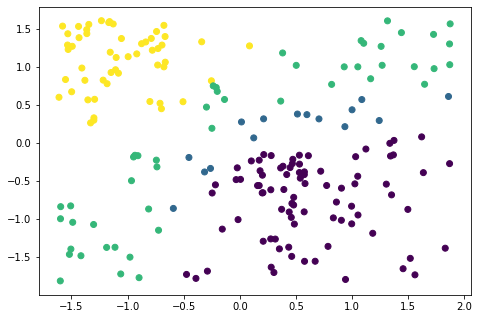

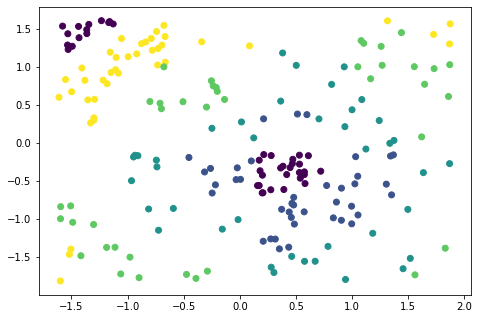

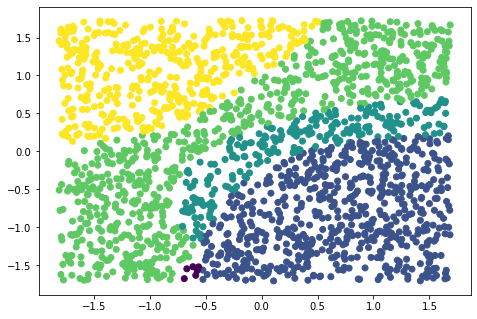

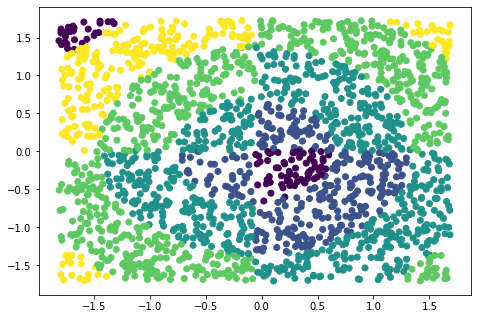

In [34]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# rings3

In [703]:
test = np.loadtxt("mio1/classification/rings3-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [704]:
test = np.loadtxt("mio1/classification/rings3-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [705]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(2,3,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(2,3,l,[sigmoid]*len(l)+[softmax],[sigmoid_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(2,3,l,[ReLU]*len(l)+[softmax],[ReLU_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="identity":
             mlp_test=MLP_new(2,3,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(2,3,l,[tanh]*len(l)+[softmax],[tanh_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("ring3-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        df=df.append({"problem":"classification","dataset":"rings3-regular","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 2316.486817825141
end epoch in 250 with error 1595.5147514236533
start error 1765.7379117047194
end epoch in 250 with error 916.1149293945823
start error 2473.1328247016213
end epoch in 60 with error 1482.3677723327241
start error 1613.3918591408199
end epoch in 250 with error 792.8782717756021
start error 1752.6035134088806
end epoch in 250 with error 1601.4726933814147
start error 2088.2014862042743
end epoch in 250 with error 1272.5228828273255
start error 4769.934174659285
end epoch in 75 with error 1482.0762352036097
start error 3037.1540245732167
end epoch in 250 with error 1112.7462024961478
start error 1691.4401859667296
end epoch in 250 with error 1480.6714172974473
start error 1600.4688827374046
end epoch in 250 with error 1276.123149003683
start error 1611.0553466432284
end epoch in 59 with error 1482.0376895316617
start error 1553.7914391593818
end epoch in 250 with error 1423.3216620404264


accuracy train
0.46066666666666667
accuracy test
0.4865


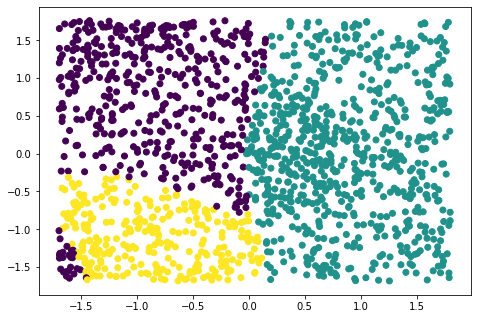

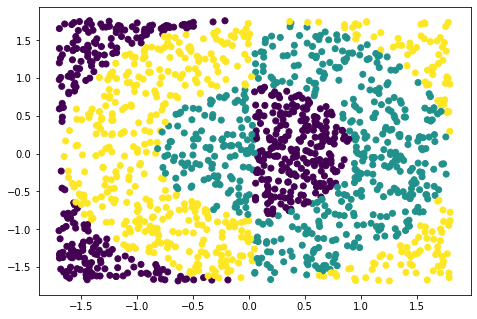

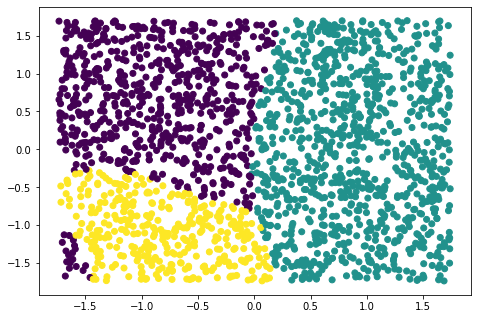

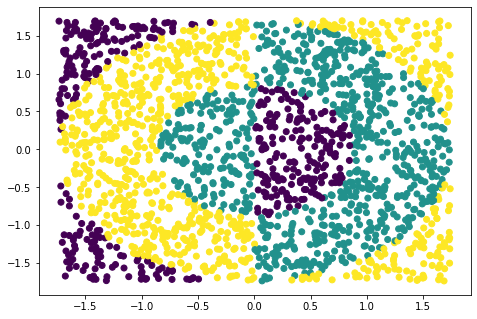

In [706]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# steps-large

In [30]:
test = np.loadtxt("mio1/regression/steps-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [31]:
test = np.loadtxt("mio1/regression/steps-large-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [32]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(1,1,l,[sigmoid]*len(l)+[identity],[sigmoid_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(1,1,l,[ReLU]*len(l)+[identity],[ReLU_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="identity":
             mlp_test=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(1,1,l,[tanh]*len(l)+[identity],[tanh_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("steps-large-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=MSE(train_output_layer,output_layer)/output_layer.shape[0]
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=MSE(test_output_layer,output_layer)/output_layer.shape[0]
        df=df.append({"problem":"regression","dataset":"steps-large","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 73726485.59413272
end epoch in 25 with error 23375811.351693857
start error 73793862.374319
end epoch in 25 with error 1201960783.620348
start error 74162630.00840524
end epoch in 25 with error 9.460952729358512e+40
start error 74009616.38020271
end epoch in 25 with error 2489819.7341565504
start error 73827428.19104879


KeyboardInterrupt: 

train MSE
32.78204764021145
test MSE
7148.923546652144


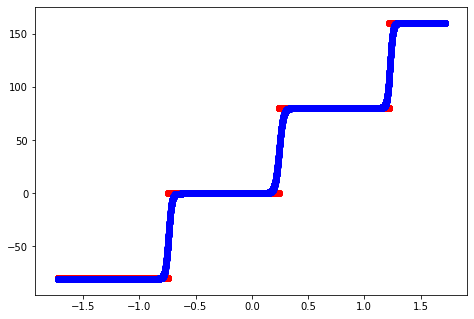

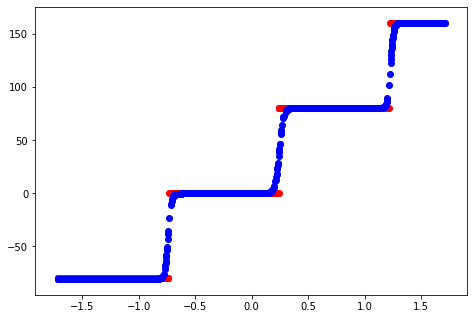

In [710]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
print("train MSE")
print(MSE(train_output_layer,output_layer)/output_layer.shape[0])

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
print("test MSE")
print(MSE(test_input_layer,output_layer)/output_layer.shape[0])

# multimodal-large

In [711]:
test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [712]:
test = np.loadtxt("mio1/regression/multimodal-large-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [714]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(1,1,l,[sigmoid]*len(l)+[identity],[sigmoid_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(1,1,l,[ReLU]*len(l)+[identity],[ReLU_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="identity":
             mlp_test=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(1,1,l,[tanh]*len(l)+[identity],[tanh_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("multimodal-large-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=MSE(train_output_layer,output_layer)/output_layer.shape[0]
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=MSE(test_output_layer,output_layer)/output_layer.shape[0]
        df=df.append({"problem":"regression","dataset":"multimodal-large","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 71661062.97467175
end epoch in 250 with error 591675.429131183
start error 71720451.05379042
end epoch in 197 with error 67127762.44853589
start error 72085993.08034731
end epoch in 250 with error 3.4053210114079235e+46
start error 71933180.51532367
end epoch in 250 with error 2608061.8740811185
start error 71756719.45057206
end epoch in 250 with error 579218.3938194523
start error 71886469.68433225
end epoch in 61 with error 67132116.43690798
start error 72717862.64916012
end epoch in 250 with error 2.3559701145421746e+35
start error 72262078.91283402
end epoch in 250 with error 644230.4283535393
start error 72021683.89802095
end epoch in 250 with error 695949.960281819
start error 72193426.44575012
end epoch in 122 with error 67126956.68566069
start error 72343178.42216009
end epoch in 250 with error 7.40824258642549e+26
start error 72000266.05542843
end epoch in 250 with error 415670.3341301546


train MSE
41.56703341301546
test MSE
6767.130694391373


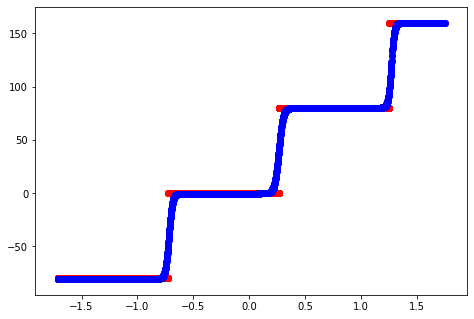

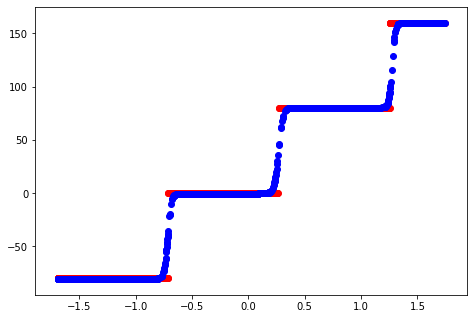

In [715]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
print("train MSE")
print(MSE(train_output_layer,output_layer)/output_layer.shape[0])

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
print("test MSE")
print(MSE(test_input_layer,output_layer)/output_layer.shape[0])

In [726]:
import seaborn as sns

In [717]:
#dla wielowarstwowych sieci gdy identity jest funkcja aktywacji to wagi eksploduja przy problemie regresji
df=df[df["accuracy_train"]<10**10]

In [718]:
df_c=df[df["problem"]=="classification"]

In [719]:
df_r=df[df["problem"]!="classification"]

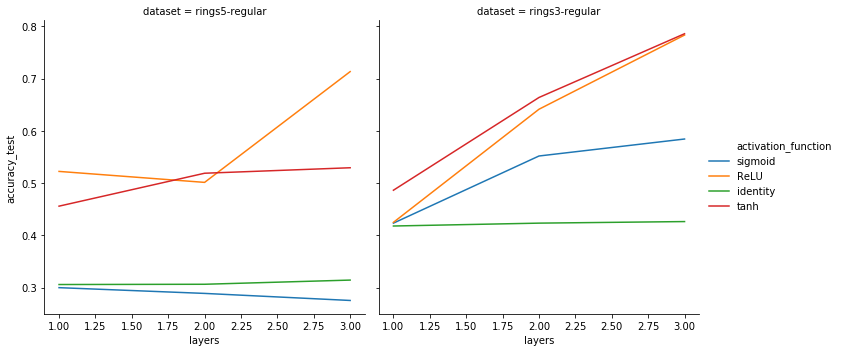

In [720]:
sns.relplot(x="layers",y="accuracy_test",hue="activation_function",col="dataset",kind="line",data=df_c)

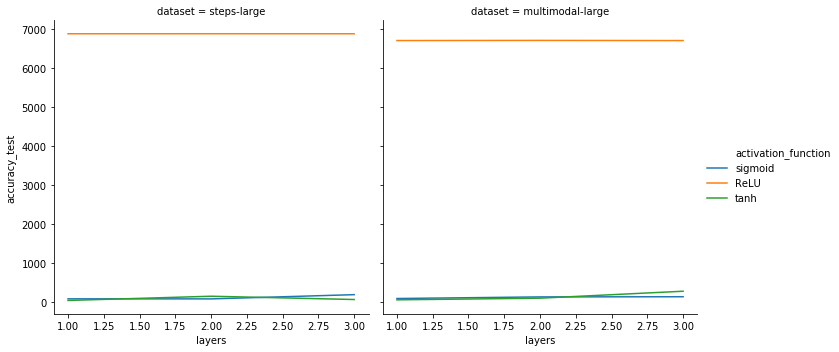

In [721]:
#dla problemu regresji im niżej tym lepiej "accuracy" to w tym wypadku MSE
sns.relplot(x="layers",y="accuracy_test",hue="activation_function",col="dataset",kind="line",data=df_r)

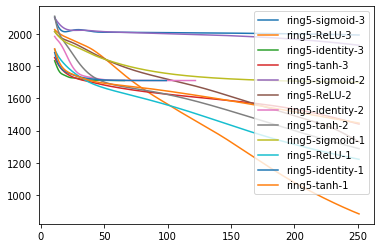

In [731]:
for x in range(0,12):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right")  

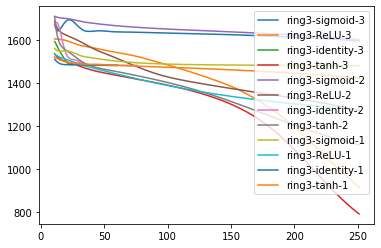

In [732]:
for x in range(12,24):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

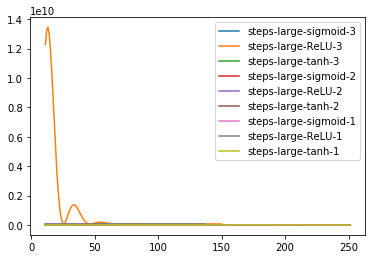

In [733]:
for x in range(24,36):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

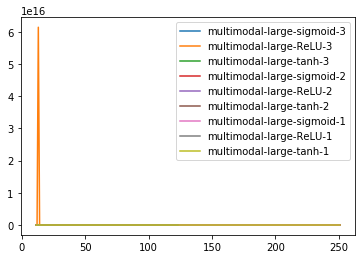

In [734]:
for x in range(36,48):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

# Space for debugging

# OLD CLASS

In [141]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [7]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [11]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len, activation_function):
        
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(self.weights[i].dot(input_layer)+self.biases[i])
                
        
        #mozliwe ze trzeba reshapy
        output_layer=(self.weights[-1].dot(input_layer)+self.biases[-1])
        #print(output_layer.shape)
        self.output_layer=output_layer.T.copy()
        
        
        return(output_layer.T)
        
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8):
        lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=sum((true_output_layer-output_layer)**2)
        print(error)
        iteration=0
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]

        for xd in range(2*10**3):
            iteration+=1

            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #derivative of x is 1
                    errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(self.hidden_layers[i][:,x:x+1])

                for l in range(1,len(self.weights)):

                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=sum((true_output_layer-output_layer)**2)
            error_list.append(new_error)

            if(iteration % 1000 == 0):
                print(iteration)

            if (abs(new_error-error)/error)<stop:
                #print((new_error-error)/error)
                #print(iteration)
                break

            error=new_error
        
        print(iteration)
        print(error)
        return error_list

In [835]:
mlp_test=MLP_test(1,1,[4,6],[sigmoid,sigmoid,identity],[sigmoid_grad,sigmoid_grad,identity_grad],MSE,MSE_grad)

In [836]:
test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

ValueError: x and y must be the same size

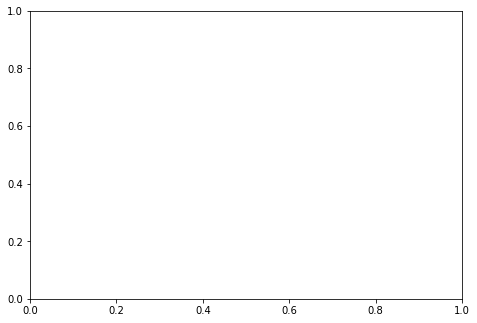

In [512]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [12]:
mlp=MLP(1,1,[15,17,19],sigmoid)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

rate=0.08

beta=0.8

batch=0.2

stop=10**-6

RMSprop=True

eps=10**-8

NameError: name 'X' is not defined

In [208]:
xd=np.ones((3,2))

In [212]:
softmax(xd)

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [214]:
sigmoid(xd)

array([[0.73105858, 0.73105858],
       [0.73105858, 0.73105858],
       [0.73105858, 0.73105858]])

In [ ]:
lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
output_layer=mlp.calculate(train_input_layer)
error=sum((true_output_layer-output_layer)**2)
iteration=0
old_gradient=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
error_list=[error]

for xd in range(1*10**1):
    iteration+=1
    
    for b in range(len(lin)-1):
        
        input_layer=train_input_layer[lin[b]:lin[b+1]]
        output_layer=mlp.calculate(input_layer,memory=True)
        batch_size=output_layer.shape[0]
        errors=[[0]*len(mlp.weights) for x in range(batch_size)]

        for x in range(batch_size):
            #derivative of x is 1
            errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

            for i in range(len(mlp.weights)-2,-1,-1): 
                errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][:,x:x+1])

        for l in range(1,len(mlp.weights)):

            if(RMSprop):
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                mlp.weights[l]=mlp.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))
                
                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
            else:
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                old_gradient[l][b]=new_gradient
                mlp.weights[l]=mlp.weights[l]-new_gradient*rate

                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                old_gradient_bias[l][b]=new_gradient_bias
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*rate

        if(RMSprop):
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
            mlp.weights[0]=mlp.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))
            
            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
            print((np.sqrt(old_gradient_bias[0][b])+eps))
        else:
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
            old_gradient[0][b]=new_gradient
            mlp.weights[0]=mlp.weights[0]-new_gradient*rate

            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
            old_gradient_bias[0][b]=new_gradient_bias
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*rate
        
        
    output_layer=mlp.calculate(train_input_layer)
    new_error=sum((true_output_layer-output_layer)**2)
    error_list.append(new_error)
    
    if(iteration % 1000 == 0):
        print(iteration)
    
    if (abs(new_error-error)/(error+eps))<stop:
        print((new_error-error)/error)
        print(iteration)
        break
    
    error=new_error

# OLD LAB

In [23]:
#square large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/square-large-training.csv", delimiter=',', skiprows=1,usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [78]:
#multimodal-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [24]:
#steps-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/steps-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [25]:
mlp_vanilla=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla.weights=mlp_start.weights.copy()
mlp_vanilla.biases=mlp_start.biases.copy()

In [26]:
mlp_vanilla_batch=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla_batch.weights=mlp_start.weights.copy()
mlp_vanilla_batch.biases=mlp_start.biases.copy()

In [27]:
mlp_RMS=MLP(1,1,[10,8,12],sigmoid)
mlp_RMS.weights=mlp_start.weights.copy()
mlp_RMS.biases=mlp_start.biases.copy()

In [28]:
mlp_momentum=MLP(1,1,[10,8,12],sigmoid)
mlp_momentum.weights=mlp_start.weights.copy()
mlp_momentum.biases=mlp_start.biases.copy()

In [35]:
error_momentum=mlp_momentum.train(train_input_layer,true_output_layer,batch=0.1)

[347.79019007]
1000
2000
2000
[27.97169648]


In [18]:
error_vanilla_batch=mlp_vanilla_batch.train(train_input_layer,true_output_layer,beta=0)

[214.80715548]
1000
2000
2000
[0.03706813]


In [19]:
error_vanilla=mlp_vanilla.train(train_input_layer,true_output_layer,batch=1,beta=0)

[214.80715548]
1000
2000
2000
[0.0089865]


In [70]:
error_RMS=mlp_RMS.train(train_input_layer,true_output_layer,RMSprop=True,beta=0.999,batch=0.1,eps=10**-8,rate=0.001)

[575.67652086]


KeyboardInterrupt: 

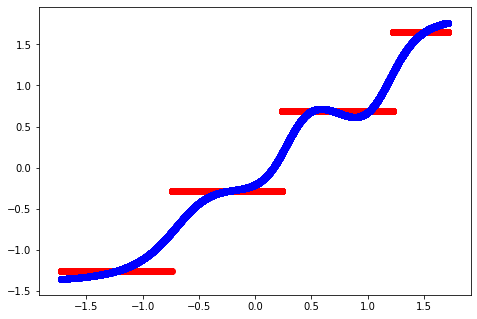

In [34]:
output_layer=mlp_momentum.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

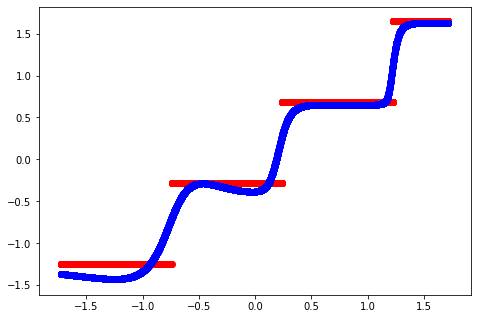

In [71]:
output_layer=mlp_RMS.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [27]:
t = np.arange(1, 2002, 1)

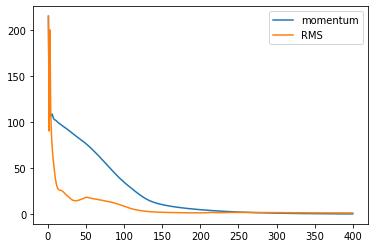

In [72]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

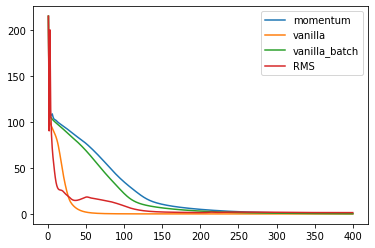

In [28]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_vanilla[0:400],label="vanilla")
plt.plot(t[0:400],error_vanilla_batch[0:400],label="vanilla_batch")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

In [ ]:
error_momentum[-1]

In [ ]:
error_vanilla[-1]

In [ ]:
error_vanilla_batch[-1]

In [ ]:
error_RMS[-1]